In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/prices-split-adjusted.csv")

df.head()


,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

# Нормалізація даних
def normalize_data(df):
    scaler = MinMaxScaler()
    for col in ['open', 'high', 'low', 'close']:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1).astype(float))
    return df, scaler

# Завантаження даних
def load_data_with_generator(stock, seq_len, target_colum = 3, valid_size=0.1, test_size=0.1):
    data_raw = stock.to_numpy()

    # Визначення розмірів наборів
    valid_size = int(valid_size * len(data_raw))
    test_size = int(test_size * len(data_raw))
    train_size = len(data_raw) - valid_size - test_size

    train_data = data_raw[:train_size]
    valid_data = data_raw[train_size:train_size + valid_size]
    test_data = data_raw[train_size + valid_size:]

    # по замовчуванню колонка `close` як таргет
    train_gen = TimeseriesGenerator(train_data[:, target_colum].astype(float), train_data[:, target_colum].astype(float), length=seq_len, batch_size=1)
    valid_gen = TimeseriesGenerator(valid_data[:, target_colum].astype(float), valid_data[:, target_colum].astype(float), length=seq_len, batch_size=1)
    test_gen = TimeseriesGenerator(test_data[:, target_colum].astype(float), test_data[:, target_colum].astype(float), length=seq_len, batch_size=1)

    return train_gen, valid_gen, test_gen

In [ ]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
def visualize_training(original_signal, train_predictions, valid_predictions, test_predictions=None, seq_len=20):
    plt.figure(figsize=(16, 10))

    # Візуалізація справжнього сигналу
    plt.plot(range(len(original_signal)), original_signal, color='blue', label='Actual Signal')

    # Довжина кожного набору
    train_len = seq_len + len(train_predictions)
    valid_len = seq_len + len(valid_predictions)
    test_len = seq_len + len(test_predictions) if test_predictions is not None else 0

    # Візуалізація прогнозів зі зміщенням
    plt.plot(np.arange(seq_len,  train_len), train_predictions, color='red', label='Train Predictions')
    plt.plot(np.arange(seq_len + train_len, train_len + valid_len), valid_predictions, color='orange', label='Validation Predictions')

    if test_predictions is not None:
        plt.plot(np.arange(seq_len + train_len + valid_len, train_len + valid_len + test_len),
                 test_predictions, color='green', label='Test Predictions')

    plt.title('Signal Forecasting (Enhanced LSTM)')
    plt.xlabel('Time Steps')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np

def calculate_model_accuracy(original_signal, train_predictions, valid_predictions, test_predictions=None, seq_len=20):

     # Довжина кожного набору
    train_len = seq_len + len(train_predictions)
    valid_len = seq_len + len(valid_predictions)
    test_len = seq_len + len(test_predictions) if test_predictions is not None else 0

    # Відновлення реальних сигналів для кожного набору
    train_actual = original_signal[seq_len:train_len]
    valid_actual = original_signal[seq_len + train_len:train_len + valid_len]
    test_actual = None
    if test_predictions is not None:
        test_actual = original_signal[seq_len + train_len + valid_len:
                                      train_len + valid_len + test_len]

    # Обчислення абсолютної похибки (MAE)
    train_mae = np.mean(np.abs(train_actual - train_predictions))
    valid_mae = np.mean(np.abs(valid_actual - valid_predictions))
    test_mae = None
    if test_actual is not None:
        test_mae = np.mean(np.abs(test_actual - test_predictions))

    # Обчислення відносної похибки (MAPE)
    train_mape = np.mean(np.abs((train_actual - train_predictions) / train_actual)) * 100
    valid_mape = np.mean(np.abs((valid_actual - valid_predictions) / valid_actual)) * 100
    test_mape = None
    if test_actual is not None:
        test_mape = np.mean(np.abs((test_actual - test_predictions) / test_actual)) * 100

    # Формування таблиці результатів
    data = {
        'Set': ['Train', 'Validation', 'Test'],
        'MAE': [train_mae, valid_mae, test_mae],
        'MAPE (%)': [train_mape, valid_mape, test_mape]
    }
    results_table = pd.DataFrame(data)

    return results_table


In [ ]:
# Тренування моделі
def train_model(model, train_generator, valid_generator, test_generator, scaler, df_stock, epochs=6, seq_len = 20):
    # Колбеки
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

    # Компільована модель
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Тренування
    history = model.fit(
        train_generator,
        epochs = epochs,
        validation_data=valid_generator,
        callbacks=[reduce_lr],
        verbose=1
    )

    # Прогнозування
    train_predictions = predict_sequenceNEW(model, train_generator, scaler)
    valid_predictions = predict_sequenceNEW(model, valid_generator, scaler)
    test_predictions = predict_sequenceNEW(model, test_generator, scaler)

    # Виклик візуалізації
    visualize_training(
      #scalerMinMax.inverse_transform(df_stock.values.reshape(-1, 1)).flatten(),
      df_stock.values.reshape(-1, 1),
      train_predictions,
      valid_predictions,
      test_predictions,
      seq_len=seq_len
    )
    visualize_training(
        scaler.inverse_transform(df_stock.values.reshape(-1, 1)).flatten(),
        scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten(),
        scaler.inverse_transform(valid_predictions.reshape(-1, 1)).flatten(),
        scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten(),
        seq_len=seq_len
        # Обчислення точності
    results = calculate_model_accuracy(
        scaler.inverse_transform(df_stock.values.reshape(-1, 1)).flatten(),
        train_predictions,
        valid_predictions,
        test_predictions,
        seq_len=seq_len
    )

    # Виведення результатів
    print(results)


    return model


In [ ]:
# Завантаження даних
STOCK_NAME = 'EQIX'
seq_len = 20
target_colum = 2

df_stock = df[df.symbol == STOCK_NAME].copy()
df_stock.drop(['symbol', 'volume'], axis=1, inplace=True)

# Нормалізація
df_stock_norm, scalerMinMax = normalize_data(df_stock)

# Генератори
# Функція прогнозування
def predict_sequenceNEW(model, generator, scaler):
    predictions = []
    for i in range(len(generator)):
        x, _ = generator[i]
        pred = model.predict(x, verbose=0)
        predictions.append(pred.flatten())
    predictions = np.array(predictions).flatten()

    # Перетворення назад у вихідний масштаб
    #return scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    return predictions

train_gen, valid_gen, test_gen = load_data_with_generator(df_stock_norm, seq_len, target_colum)
df[df.symbol == STOCK_NAME]

,date,symbol,open,close,low,high,volume
399,2010-01-04,EQIX,106.519997,109.559998,106.510002,109.620003,576300.0
867,2010-01-05,EQIX,109.589996,108.540001,108.379997,109.589996,681900.0
1335,2010-01-06,EQIX,108.949997,109.529999,108.220001,110.570000,1397500.0
1803,2010-01-07,EQIX,109.250000,107.290001,106.639999,110.349998,797200.0
2271,2010-01-08,EQIX,106.800003,106.769997,105.900002,107.279999,432400.0
...,...,...,...,...,...,...,...
848919,2016-12-23,EQIX,352.100006,356.609985,350.369995,358.140015,338100.0
849419,2016-12-27,EQIX,356.779999,356.720001,355.109985,359.649994,294600.0
849919,2016-12-28,EQIX,357.220001,353.859985,353.429993,359.549988,291600.0
850419,2016-12-29,EQIX,353.420013,357.089996,351.890015,358.929993,372000.0


# LSTM

In [ ]:
# Модель LSTM
def EnhancedLSTM(input_shape=(20, 1)):
    model = Sequential()

    model.add(LSTM(200, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

    model.summary()
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         168,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 338,369 (1.29 MB)

 Trainable params: 338,369 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1390/1390 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0045 - mae: 0.0434 - val_loss: 0.0055 - val_mae: 0.0703 - learning_rate: 0.0010
Epoch 2/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 8.2767e-04 - mae: 0.0223 - val_loss: 0.0042 - val_mae: 0.0615 - learning_rate: 0.0010
Epoch 3/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 7.4529e-04 - mae: 0.0213 - val_loss: 0.0014 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 4/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 7.2792e-04 - mae: 0.0208 - val_loss: 6.9385e-04 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 5/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 6.5956e-04 - mae: 0.0198 - val_loss: 3.7056e-04 - val_mae: 0.0140 - learning_rate: 0.0010
Epoch 6/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 5.8442e-04 - mae: 0.0187 - val_loss: 6.0212e-04 - val_mae: 0.0207 - learning_rate: 0.0010
Epoch 7/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 6.1592e-04 - mae: 0.0188 - val_loss: 8.1759e-

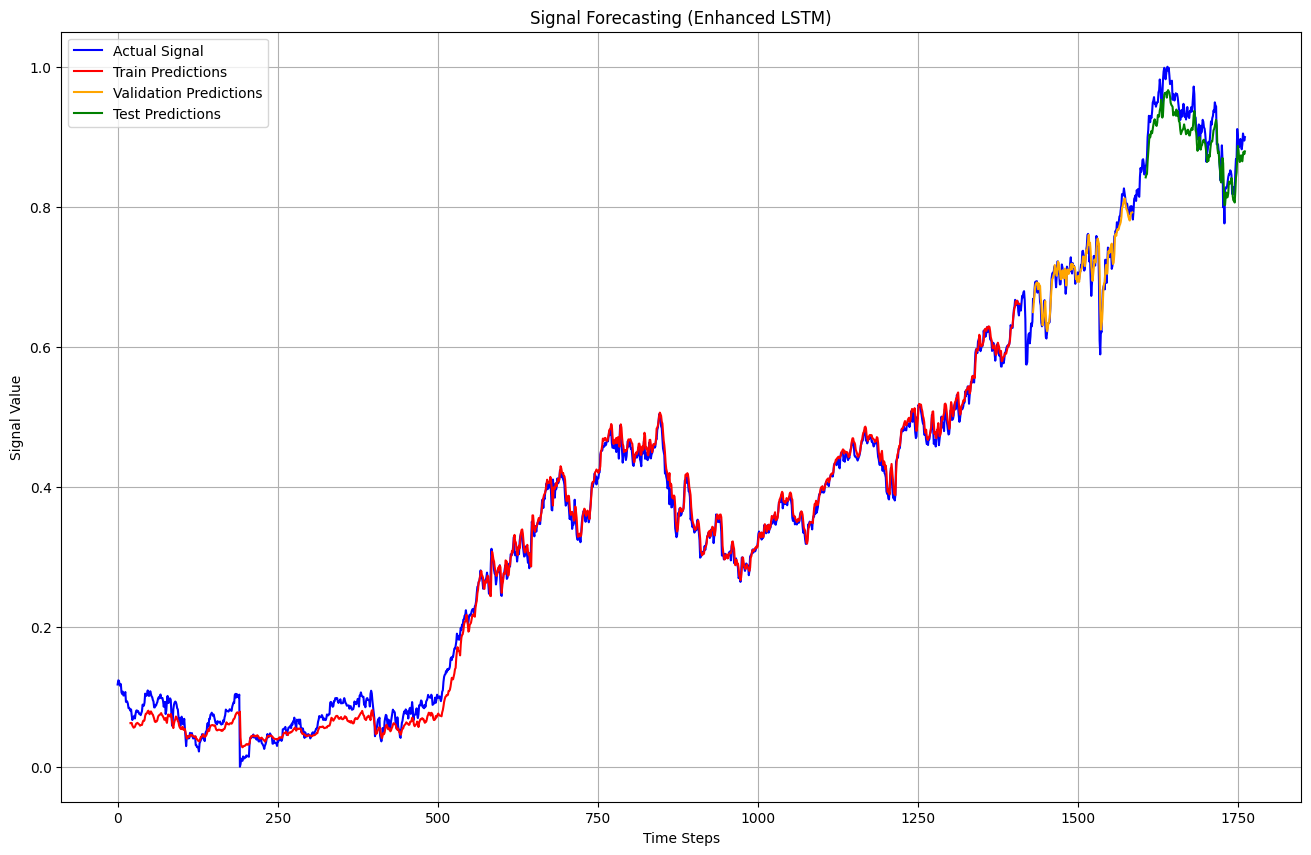

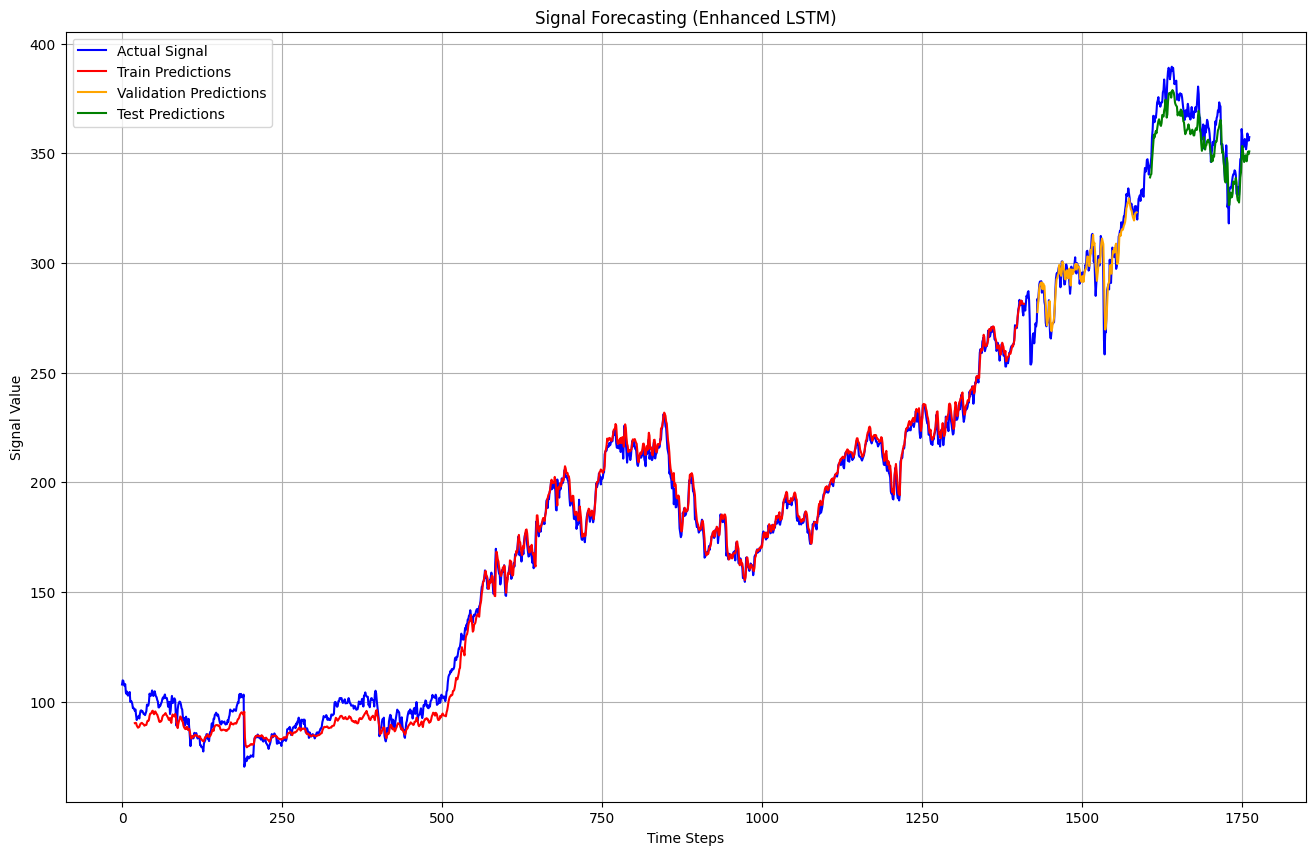

          Set        MAE   MAPE (%)
0       Train  160.15373  99.848977
1  Validation  297.60027  99.760243
2        Test  361.36819  99.753165


In [ ]:
# Побудова моделі
model = EnhancedLSTM(input_shape=(seq_len, 1))

# Тренування
trained_model = train_model(model, train_gen, valid_gen, test_gen, scalerMinMax, df_stock_norm['low'], epochs=10)

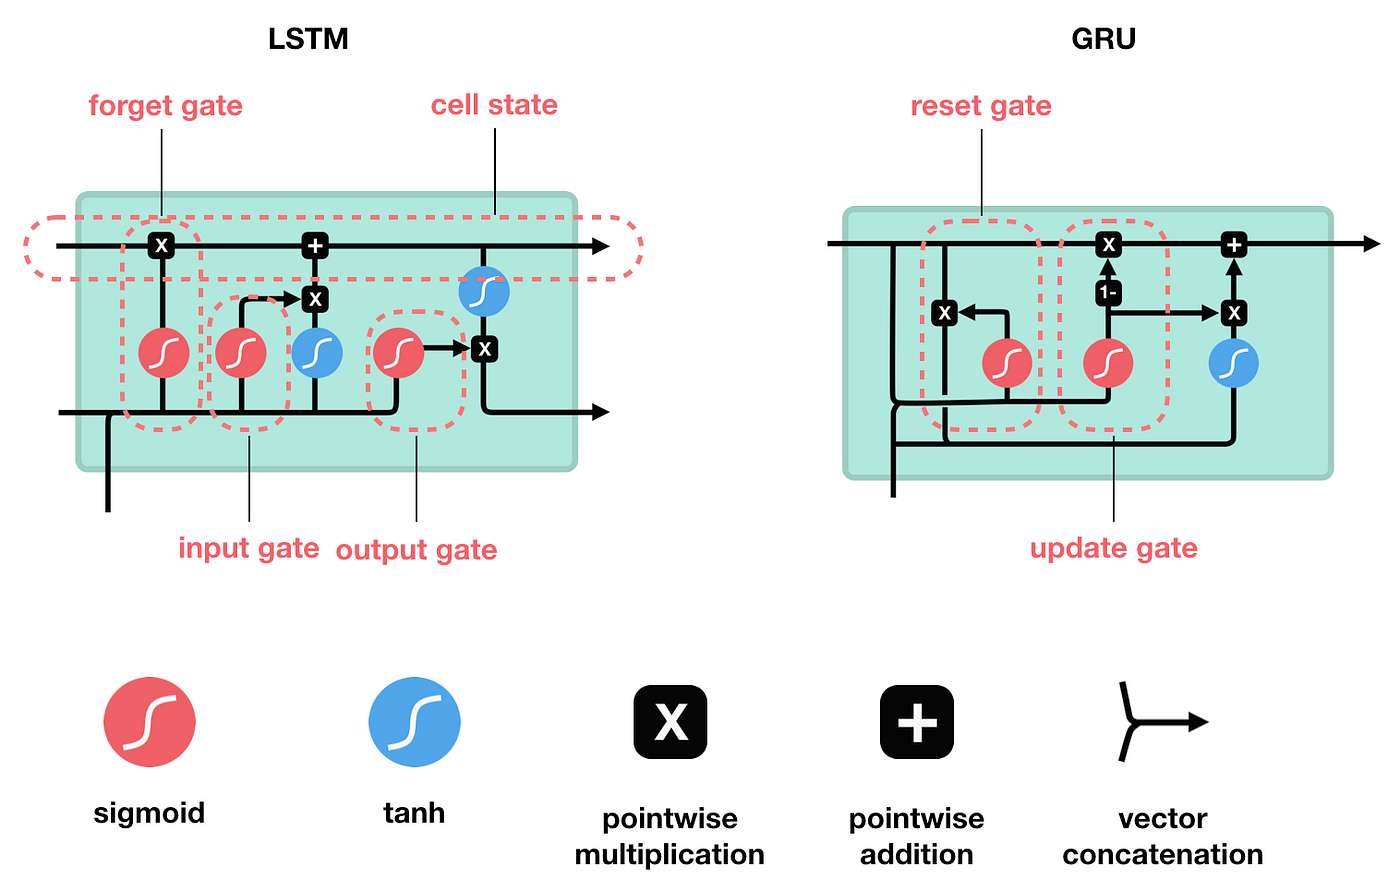

# GRU

In [ ]:
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional, GRUCell, SimpleRNN
def EnhancedGRUCell2(input_shape=(20, 1)):
    model = Sequential()
    model.add(GRU(units=250,activation='tanh',
					return_sequences=True,
					input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(GRU(units=250,activation='tanh'))
    model.add(Dropout(0.2))

    # Щільні шари
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Прогнозування одного значення

    model.summary()
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 20, 250)             │         189,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 250)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 250)                 │         376,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 582,379 (2.22 MB)

 Trainable params: 582,379 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0036 - mae: 0.0377 - val_loss: 3.6288e-04 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 2/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0010 - mae: 0.0255 - val_loss: 0.0020 - val_mae: 0.0426 - learning_rate: 0.0010
Epoch 3/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 8.0666e-04 - mae: 0.0219 - val_loss: 0.0057 - val_mae: 0.0735 - learning_rate: 0.0010
Epoch 4/10
1385/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0077e-04 - mae: 0.0201
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.0121e-04 - mae: 0.0201 - val_loss: 7.3214e-04 - val_mae: 0.0240 - learning_rate: 0.0010
Epoch 5/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 4.2707e-04 - mae: 0.0162 - val_loss: 0.0010 - val_mae: 0.0292 - learning_rate: 5.0000e-04
Epoch 6/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3.6632e-04 - mae: 0.0153 - val_loss:

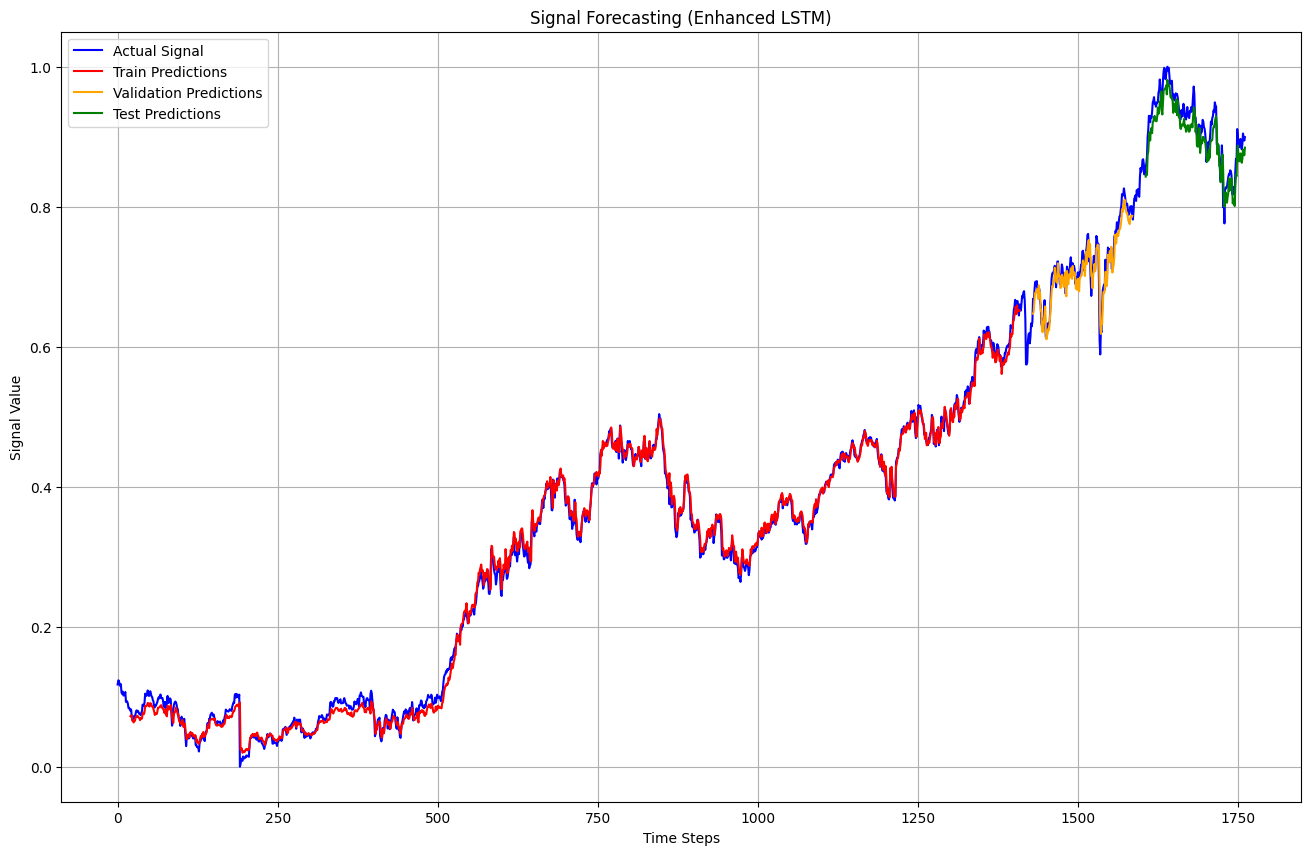

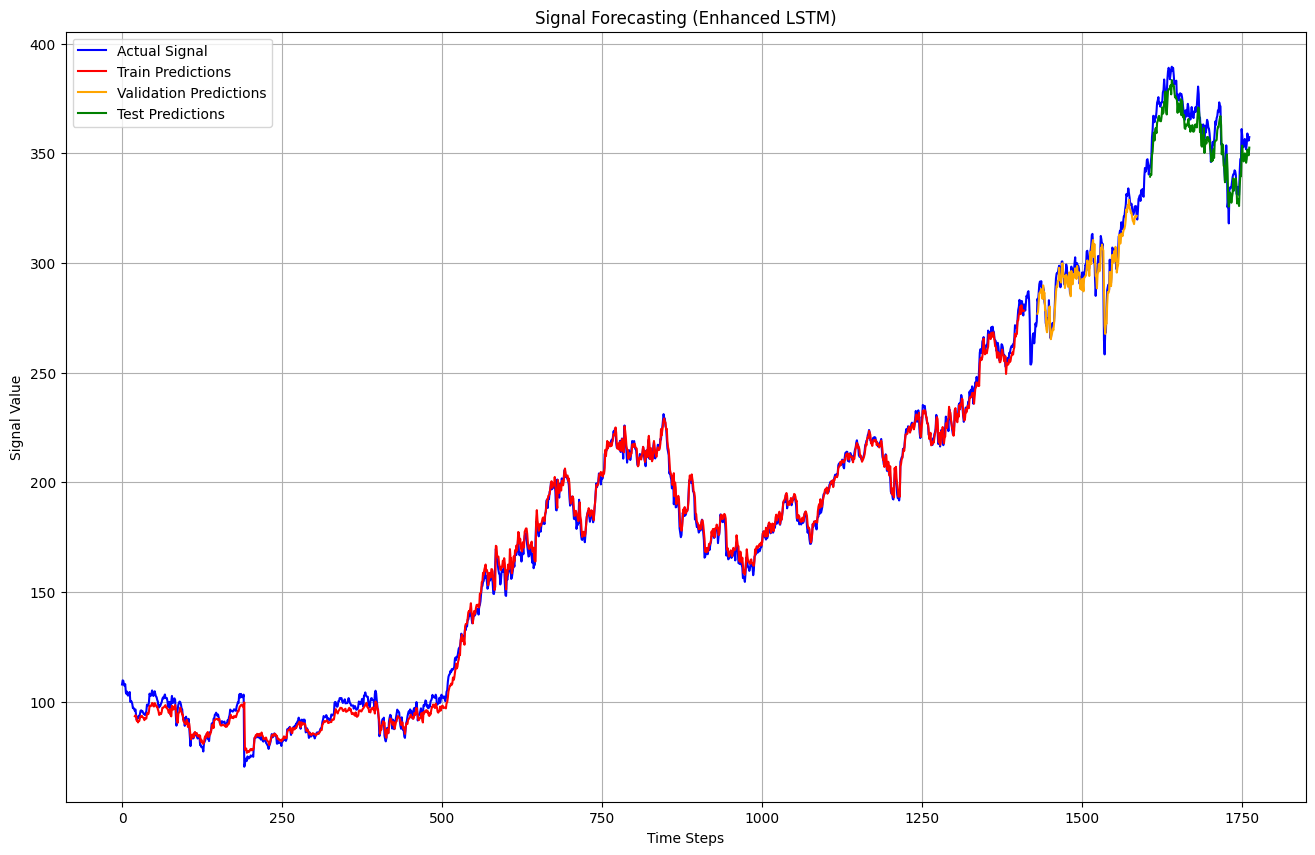

          Set         MAE   MAPE (%)
0       Train  160.152254  99.846548
1  Validation  297.608462  99.763033
2        Test  361.364048  99.752062


In [ ]:
# Побудова моделі
modelGRUCell2 = EnhancedGRUCell2(input_shape=(seq_len, 1))

# Тренування
trained_modelGRUCell = train_model(modelGRUCell2, train_gen, valid_gen, test_gen, scalerMinMax, df_stock['low'], epochs=10)


# SimpleRNN

RNN 200-200-200-D64
RNN 250-150-50-D64


In [ ]:
def EnhancedRNN(input_shape=(20, 1)):
    model = Sequential()
    model.add(SimpleRNN(units = 64,
						activation = "tanh",
						return_sequences = True,
					  input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units = 32,
                activation = "tanh",
                return_sequences = True))
    model.add(Dropout(0.2))

    model.add( SimpleRNN(units = 32))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Прогнозування одного значення

    model.summary()
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 20, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 20, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,497 (41.00 KB)

 Trainable params: 10,497 (41.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0310 - mae: 0.1077 - val_loss: 0.0052 - val_mae: 0.0641 - learning_rate: 0.0010
Epoch 2/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0024 - mae: 0.0369 - val_loss: 0.0105 - val_mae: 0.0976 - learning_rate: 0.0010
Epoch 3/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0015 - mae: 0.0304 - val_loss: 0.0024 - val_mae: 0.0418 - learning_rate: 0.0010
Epoch 4/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0130 - mae: 0.0696 - val_loss: 0.0411 - val_mae: 0.1974 - learning_rate: 0.0010
Epoch 5/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0048 - mae: 0.0527 - val_loss: 0.0068 - val_mae: 0.0717 - learning_rate: 0.0010
Epoch 6/15
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - mae: 0.0532
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0050 - mae: 0.0532 - val_loss: 0.0294 - val_mae: 0.1652 - learni

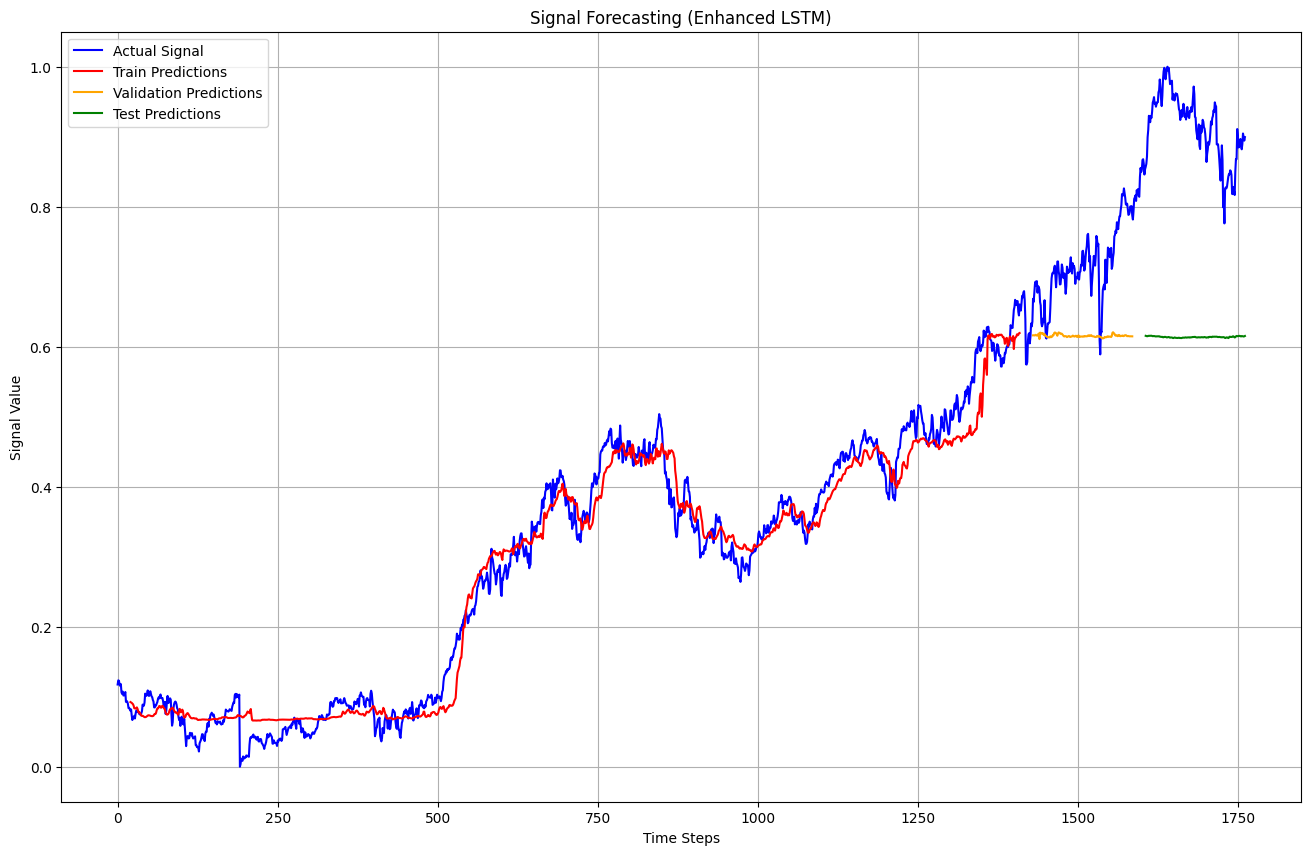

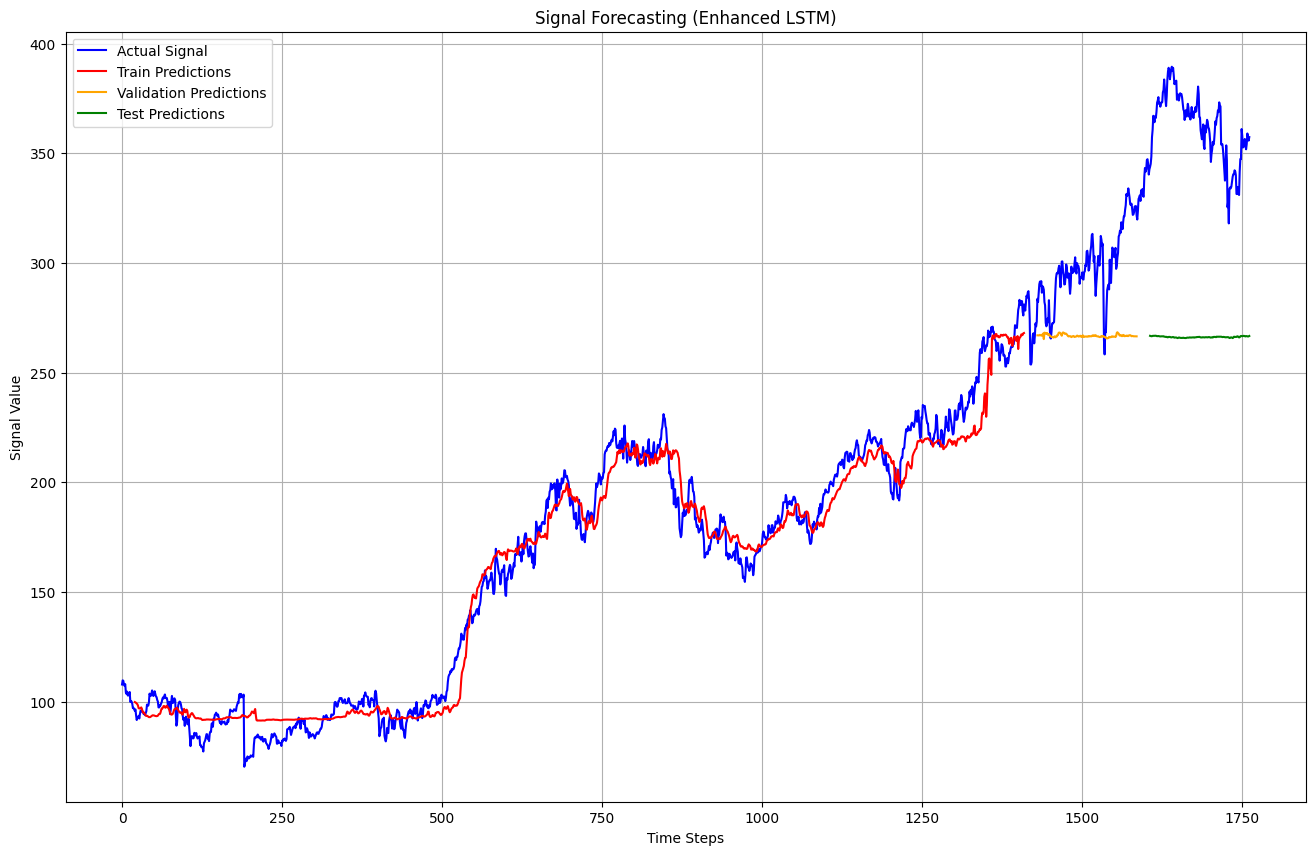

          Set         MAE   MAPE (%)
0       Train  160.156317  99.846105
1  Validation  297.700079  99.793048
2        Test  361.648538  99.830234


In [ ]:
# Побудова моделі
modelSimpleRNN = EnhancedRNN(input_shape=(seq_len, 1))

# Тренування
trained_modelSimpleRNN = train_model(modelSimpleRNN, train_gen, valid_gen, test_gen, scalerMinMax, df_stock['low'], epochs = 15)

In [ ]:
def EnhancedRNN2(input_shape=(20, 1)):
    model = Sequential()
    model.add(SimpleRNN(units = 200,
						activation = "elu",
						return_sequences = True,
					  input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units = 150,
                activation = "elu",
                return_sequences = True))
    model.add(Dropout(0.2))

    model.add( SimpleRNN(units = 32))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Прогнозування одного значення

    model.summary()
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 20, 200)             │          40,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 20, 150)             │          52,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 32)                  │           5,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,995 (390.61 KB)

 Trainable params: 99,995 (390.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0231 - mae: 0.0990 - val_loss: 0.0257 - val_mae: 0.1543 - learning_rate: 0.0010
Epoch 2/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0562 - mae: 0.1863 - val_loss: 0.2274 - val_mae: 0.4745 - learning_rate: 0.0010
Epoch 3/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0416 - mae: 0.1724 - val_loss: 0.1101 - val_mae: 0.3284 - learning_rate: 0.0010
Epoch 4/10
1381/1390 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384 - mae: 0.1670
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0384 - mae: 0.1670 - val_loss: 0.2409 - val_mae: 0.4885 - learning_rate: 0.0010
Epoch 5/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0362 - mae: 0.1653 - val_loss: 0.1660 - val_mae: 0.4046 - learning_rate: 5.0000e-04
Epoch 6/10
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0368 - mae: 0.1675 - val_loss: 0.1698 - val_mae: 0.4092 - lear

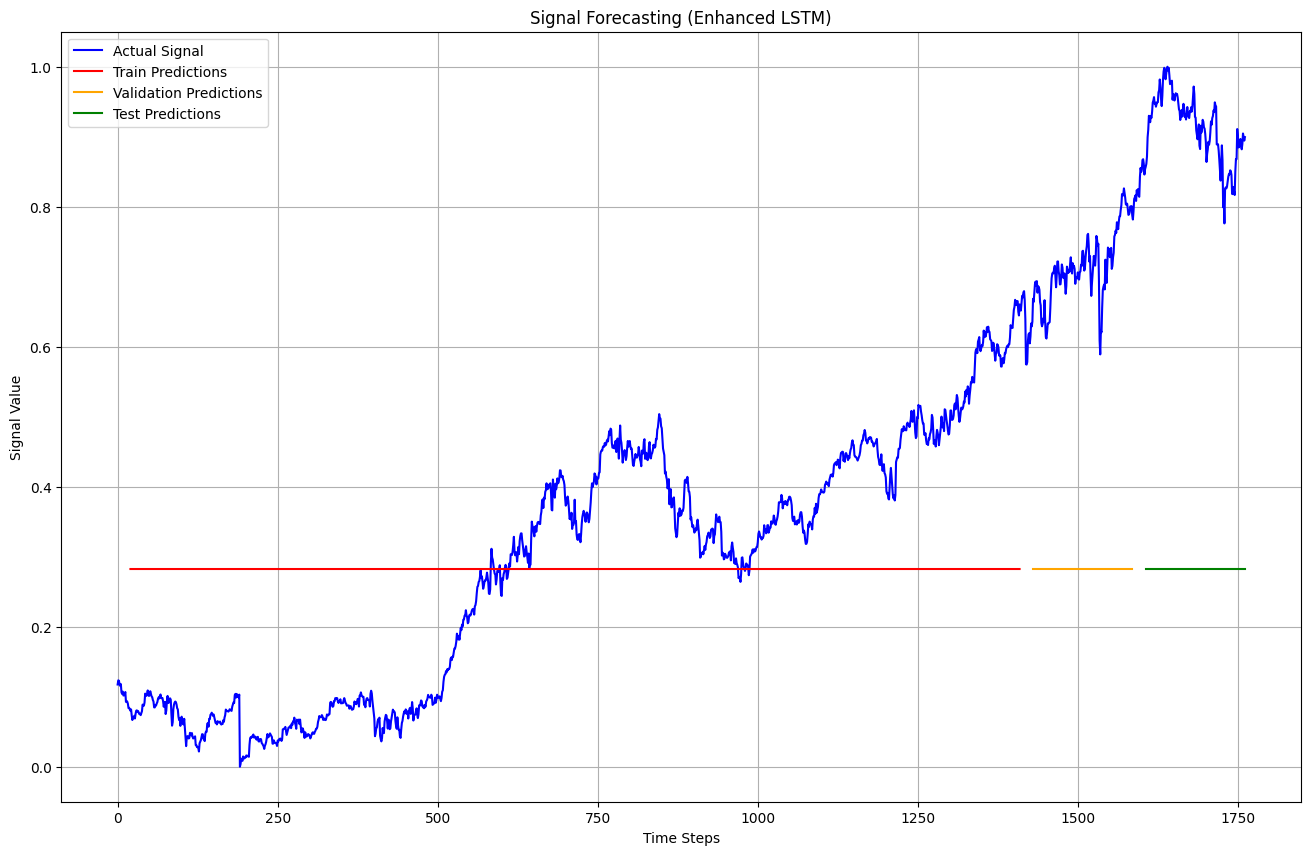

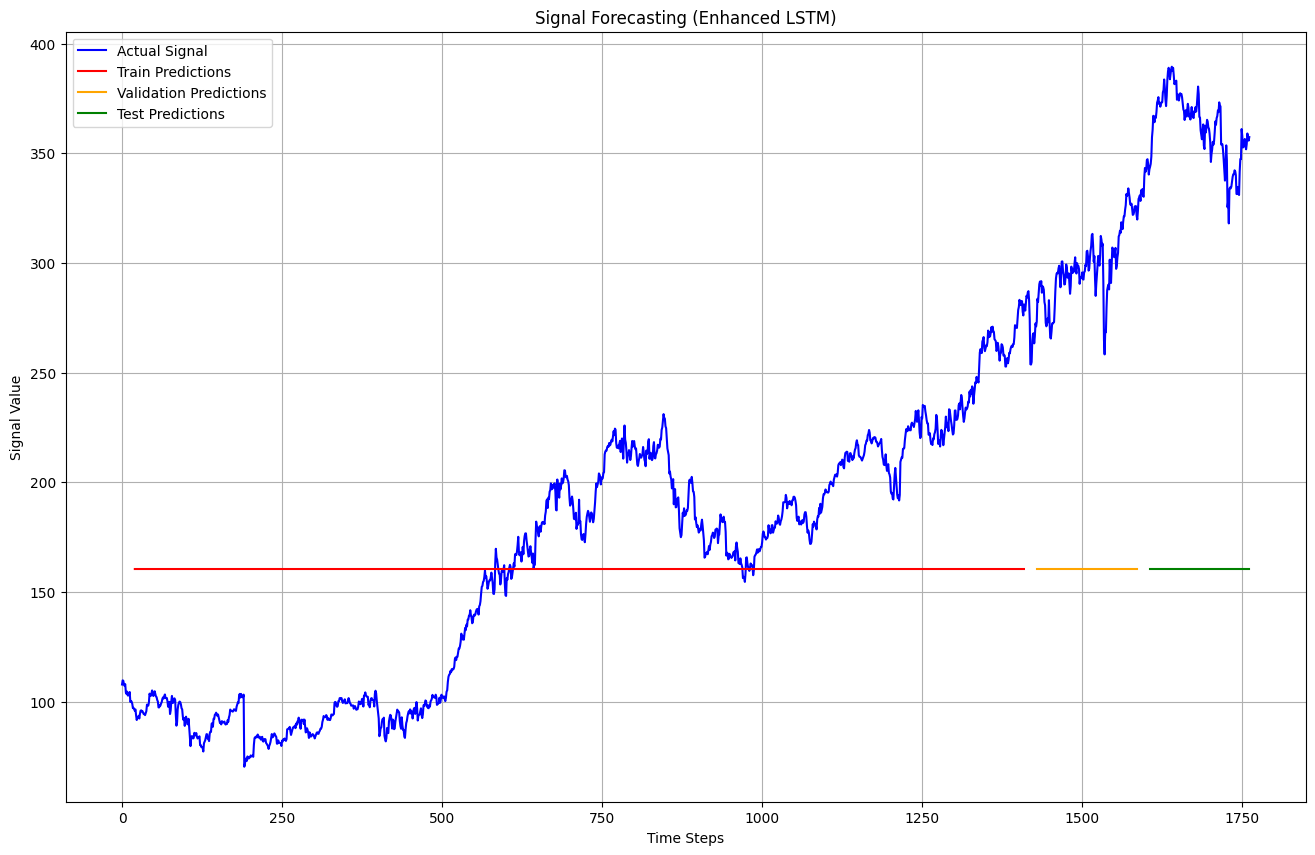

          Set         MAE   MAPE (%)
0       Train  160.151793  99.795996
1  Validation  298.033241  99.905049
2        Test  361.979967  99.921891


In [ ]:
# Побудова моделі
modelSimpleRNN2 = EnhancedRNN2(input_shape=(seq_len, 1))

# Тренування
trained_modelSimpleRNN2 = train_model(modelSimpleRNN2, train_gen, valid_gen, test_gen, scalerMinMax, df_stock['low'], epochs = 10)

In [ ]:
def EnhancedGRUCell2(input_shape=(20, 1)):
    model = Sequential()
    model.add(RNN(GRUCell(units=200,activation='tanh'),
					return_sequences=True,
					input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(RNN(GRUCell(units=150,activation='tanh')))
    model.add(Dropout(0.2))

    # Щільні шари
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Прогнозування одного значення

    model.summary()
    return model

In [ ]:
# Побудова моделі
modelGRUCell2 = EnhancedGRUCell2(input_shape=(seq_len, 1))

# Тренування
trained_modelGRUCell2 = train_model(modelGRUCell2, train_gen, valid_gen, test_gen, scalerMinMax, df_stock['low'], epochs = 15)